In [1]:
!pip install pytorch_lightning tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which

In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

In [3]:
data = pd.read_json("/kaggle/input/rec-sys/data.json", lines=True)

In [4]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [5]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

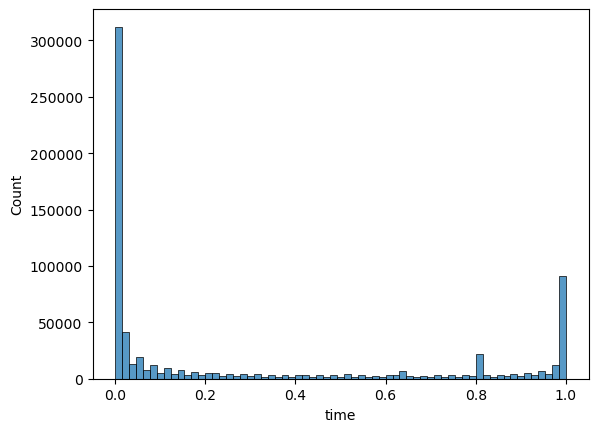

In [6]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax);

In [7]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [8]:
features = ["start", "track"]

In [9]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=256):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(50000, embedding_dim)
        self.track = nn.Embedding(50000, embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0])
        track = self.track(x[:, 1])
        return torch.sum(context * track, dim=1)
            
    
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss
    
    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        avgs = y[:, 0].float()
        targets = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [10]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):

        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
                )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
                )
        
        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
        
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=2)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=2)

In [11]:
train_dataset = td.TensorDataset(
    torch.from_numpy(train_data[features].values), 
    torch.from_numpy(train_data["time"].values)
)

val_dataset = td.TensorDataset(
    torch.from_numpy(val_data[features].values), 
    torch.from_numpy(val_data["time"].values)
)

In [12]:
net = ContextualRanker()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=200,
    accelerator='gpu', 
    devices=-1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

In [13]:
trainer.fit(
    net, 
    td.DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0),
    td.DataLoader(val_dataset, batch_size=2048, num_workers=0)
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00139: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00146: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

In [14]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path)

In [15]:
data_module = ContextualRankerData(train_data, val_data, test_data, features = features)
trainer.test(best, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.15447917580604553    │
│         rdm_loss          │    0.12296579778194427    │
│         test_loss         │    0.06423962116241455    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06423962116241455,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.12296579778194427}]

In [16]:
test_loader = td.DataLoader(torch.from_numpy(test_data[features].values), batch_size=512, shuffle=False, num_workers=0)

nn_predictions = []
for batch in tqdm.tqdm(test_loader, total=test_data.shape[0] / 512):
    nn_predictions.extend(best(batch).detach().numpy().tolist())

141it [00:00, 684.26it/s]                                  


In [17]:
eval_data = test_data.copy().assign(nn = nn_predictions).assign(rdm = np.random.random(len(test_data))).assign(avg = train_data["time"].mean()).head()

In [18]:
# sm.mean_squared_error(eval_data["nn"], eval_data["time"])

In [19]:
# sm.mean_squared_error(eval_data["rdm"], eval_data["time"])

In [20]:
# sm.mean_squared_error(eval_data["avg"], eval_data["time"])

In [21]:
track_meta = pd.read_json("/kaggle/input/rec-sys/tracks.json", lines=True)

In [22]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [23]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [24]:
k = 100
with open("recommendations_nn.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [22:37, 36.82it/s]


In [25]:
track = 1982
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
1982,Rammstein,Engel


In [26]:
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
129,John Mayer,Heartbreak Warfare
153,Eminem,Without Me
156,Björk,Undo
159,Dwight Yoakam,You're The One
178,Lil Wayne / Eminem,Drop The World
...,...,...
21565,Rammstein,Ich Will
23869,rinôçérôse,Music Kills Me
25743,Rammstein,REISE_ REISE
27519,Basshunter,Vi sitter i Ventrilo och Spelar DotA (Club Ver...
